In [42]:
import os 

import numpy as np
import pandas as pd
import scipy 

import progressbar

import re
import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt



% matplotlib inline


In [2]:
data = pd.read_csv('../data/cleaned_subset.csv', encoding='latin1')
data.columns.values

array(['Id', 'Title', 'Description', 'LikeCount', 'DislikeCount',
       'ViewCount', 'FavoriteCount', 'CommentCount', 'PublishedAt',
       'Channel Id', 'Channel Title', 'Tags', 'Thumbnail Default'], dtype=object)

In [79]:
data.shape

(10517, 6)

In [78]:
data = data[['Id', 'Title', 'Description', 'ViewCount', 'LikeCount', 'DislikeCount']]
data = data[data['Id'] != '#NAME?']
data = data.drop_duplicates(subset='Id', keep='last')

data.head()

,Id,Title,Description,ViewCount,LikeCount,DislikeCount
0,AUzyaHo0QQc,300 pushups a day for 20 days!! - Results!!,**NEW** (2016) Abs Workout for 30 Days | https...,13577683,40408,10312
1,1Zgtdb7jp60,John Cena - gym,Follow John Cena on twitter: http://www.twitte...,9986096,37867,1486
2,1Sfii7rnkJQ,Bodybuilding Motivation - No Time To Waste,Follow me:\nhttp://instagram.com/shaqx.bb\nhtt...,8532402,17688,1291
3,UUwSKJjx9Go,Most Powerful Home Chest Workout Ever : Build ...,http://www.6weeksixpack.com This is one of the...,8301027,46293,2589
4,Yl3NGvna2KA,Greg Plitt Best of The Best Workout Video Prev...,SIGN UP TODAY - http://bit.ly/jointheranks\r\n...,7141821,24784,1134


In [63]:
def RemoveByteArrayResidue(s):
    if len(s) > 3:
        if s[0] == 'b':
            if (s[1] == '\'' or s[1] == '\"') and (s[-1] == '\'' or s[-1] == '\"'):
                return s[2:-1]
    return s

# Remove the b'' if it exists
data['Title'] = data['Title'].apply(RemoveByteArrayResidue)
data['Description'] = data['Description'].apply(RemoveByteArrayResidue)

In [64]:
df = data.copy()

In [67]:
def tokenizer(s):
    regex_backslash = re.compile(r'\\n|\\')
    s = (regex_backslash.sub(" ", s))
    tokenizer = RegexpTokenizer(r'\w+|![^\w\s]+')
    return tokenizer.tokenize(s)
    
def num_tokens_in_str(s):
    s = tokenizer(s)
    return len(s)

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

def GetTopKImportantWords(df, k, showprogress=False):
    allWords = df[['Title', 'Description']].apply(lambda x: x[0] + x[1], axis=1)

    tf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenizer)
    tf.fit(allWords)

    tfidf_title = tf.transform(df['Title'])
    tfidf_desc = tf.transform(df['Description'])
    top_list = []


    for tfidf in [tfidf_title, tfidf_desc]:
        dense = tfidf.todense()

        if showprogress:
            bar = progressbar.ProgressBar(max_value=len(dense))

        top_words = []
        feature_names = tf.get_feature_names()
        for i, sample in enumerate(dense):
            sample = np.array(sample.tolist()[0])
            scores = sample[sample > 0]
            words = pd.Series(feature_names)[sample > 0]
            scores = pd.Series(scores, words).sort_values(ascending=False)
            top_words.append(pd.Series(scores.index[0:k]))
            
            if showprogress:
                bar.update(i)
        top_list.append(pd.concat(top_words, axis=1).T)

    for i in range(k):
        df['Title-TopWords-{0}'.format(i + 1)] = top_list[0][i]
    for i in range(k):
        df['Description-TopWords-{0}'.format(i + 1)] = top_list[1][i]
    return df

In [69]:
df = GetTopKImportantWords(df, 3, showprogress=True)

 99% (11057 of 11061) |################## | Elapsed Time: 0:01:40 ETA:  0:00:00

In [77]:
df.head(20)

,Id,Title,Description,ViewCount,LikeCount,DislikeCount,Title-TopWords-1,Title-TopWords-2,Title-TopWords-3,Description-TopWords-1,Description-TopWords-2,Description-TopWords-3,NumTokens-Title,NumTokens-Description
0,AUzyaHo0QQc,300 pushups a day for 20 days!! - Results!!,**NEW** (2016) Abs Workout for 30 Days | https...,13577683,40408,10312,!!,300,pushups,6p,8p,5p,10,194
1,1Zgtdb7jp60,John Cena - gym,Follow John Cena on twitter: http://www.twitte...,9986096,37867,1486,cena,john,gym,cena,johncena,john,3,32
2,1Sfii7rnkJQ,Bodybuilding Motivation - No Time To Waste,Follow me:\nhttp://instagram.com/shaqx.bb\nhtt...,8532402,17688,1291,waste,motivation,time,sentinel,celldweller,shaqxbb,6,34
3,UUwSKJjx9Go,Most Powerful Home Chest Workout Ever : Build ...,http://www.6weeksixpack.com This is one of the...,8301027,46293,2589,chest,powerful,ever,chest,home,powerful,11,82
4,Yl3NGvna2KA,Greg Plitt Best of The Best Workout Video Prev...,SIGN UP TODAY - http://bit.ly/jointheranks\r\n...,7141821,24784,1134,gregplitt,plitt,preview,gregplitt,added,metaphor,11,161
5,EBVTMSKY-Cw,BODYBUILDING MOTIVATION - How Bad Do You Want It?,Subscribe and Stay Tuned! Visit my channel and...,6799110,20440,1465,bad,motivation,want,yates,lux,nenez,8,82
6,y04s-zEl5GM,From Game Addicted to Sponsored Athlete: Body ...,[FREE] How To Build a Fitness Model Body Witho...,6127532,31840,2825,addicted,game,sponsored,xeniosfitness,xf0,xenios,8,252
7,y04s-zEl5GM,From Game Addicted to Sponsored Athlete: Body ...,[FREE] How To Build a Fitness Model Body Witho...,6124445,31829,2825,addicted,game,sponsored,xeniosfitness,xf0,xenios,8,252
8,Ff84gG3bgVI,Six Pack Abs Core Workout,Supplements I take which help:\nhttp://shakeli...,5889151,36295,1225,six,pack,core,shakelightly,watley,roses,5,27
9,jLS7S-nRS70,Arnold Schwarzenegger ''Bodybuilders Today Are...,Get paid to do what you love; making content. ...,5772008,43314,1361,accepted,talent,schwarzenegger,monster,856976977761656,tubebuddy,15,65


In [71]:
social_media_tags = [
    'follow',
    'subscribe',
    'like',
    'twitter',
    'facebook',
    'instagram',
]

clickbait_words = [
    ''
]

In [72]:
df['NumTokens-Title'] = df['Title'].apply(num_tokens_in_str)
df['NumTokens-Description'] = df['Description'].apply(num_tokens_in_str)

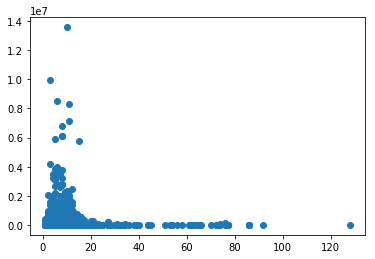

In [73]:
plt.scatter(df['NumTokens-Title'], df['ViewCount'])

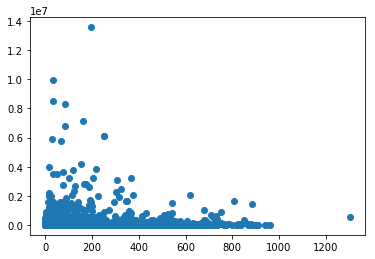

In [74]:
plt.scatter(df['NumTokens-Description'], df['ViewCount'])

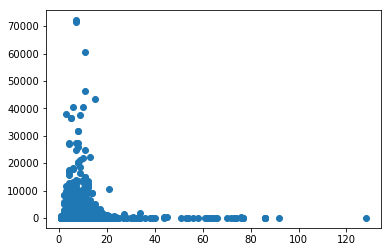

In [75]:
plt.scatter(df['NumTokens-Title'], df['LikeCount'])

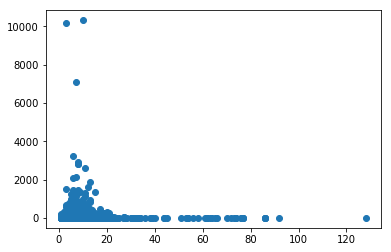

In [76]:
plt.scatter(df['NumTokens-Title'], df['DislikeCount'])